In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Nov 12 21:08:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%matplotlib inline
import argparse
import json
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

from expert import Expert
from expert import AffineExpert
from expert import TranslationExpert
from expert import ConvolutionExpert
from discriminator import Discriminator
from discriminator import ConvolutionDiscriminator
from data import translated_gaussian_dataset
from data import single_translated_gaussian_dataset
from data import transformed_mnist_dataset
from data_utils import generated_transformed_mnist
from train_utils import initialize_experts
from train_utils import train_icm
from train_utils import train_gan

# New Section

In [3]:
generated_transformed_mnist('./', 2, add_rotation=False)
os.listdir('./')
# source_data = np.load("mnist_transformed_data_2_transform.npy", allow_pickle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


['.config',
 '__pycache__',
 'data_utils.py',
 'train.py',
 'expert.py',
 'train_utils.py',
 'layers.py',
 'MNIST',
 'mnist_original_data_2_transform.npy',
 'data.py',
 'mnist_transformed_data_2_transform.npy',
 'discriminator.py',
 'drive',
 'sample_data']

In [85]:
args = argparse.Namespace()
args.batch_size = 64
args.num_initialize_epoch = 30
args.min_initialization_loss = 0.1
args.num_epoch = 100
args.discriminator_output_size = 1
# args.input_shape = 2
args.input_shape = [28, 28, 1]
args.use_sn = True
args.num_experts = 10
args.discriminator_sigmoid = False
args.noise_scale = 0.1
args.print_iterval = 200
args.no_source_target = False
args.num_transform = 2

args.cuda = torch.cuda.is_available()
args.device = torch.device("cuda:0" if args.cuda else "cpu")
print(args.cuda)
print(args.device)

True
cuda:0


In [86]:
def transformed_mnist_dataset(batch_size, args):
    num_transform = args.num_transform

    original_data_name = "mnist_original_data"
    transformed_data_name = "mnist_transformed_data"
    if num_transform > 1:
        original_data_name += "_{}_transform.npy".format(num_transform)
        transformed_data_name += "_{}_transform.npy".format(num_transform)

    source_data = np.load(original_data_name, allow_pickle=True)
    target_data = np.load(transformed_data_name, allow_pickle=True)

    source_data = np.transpose(source_data, [0, 3, 1, 2])
    target_data = np.transpose(target_data, [0, 3, 1, 2])

    np.random.shuffle(source_data)
    np.random.shuffle(target_data)

    target_size = target_data.shape[0]
    source_size = source_data.shape[0]
    multiple = target_size // (source_size * 2)
    source_data = np.concatenate([source_data] * multiple, axis=0)
    target_data = target_data[: source_size * multiple]

    tensor_src = torch.Tensor(source_data)
    tensor_tgt = torch.Tensor(target_data)
    print(tensor_src.size(), tensor_tgt.size())

    dataset = torch.utils.data.TensorDataset(tensor_src, tensor_tgt)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=int(args.cuda),
        pin_memory=args.cuda,
        drop_last=True,
    )
    return dataloader

In [87]:
# Data
# data = single_translated_gaussian_dataset(args.batch_size, args, args.noise_scale)
# data = translated_gaussian_dataset(args.batch_size, args, dist=2.0)
data = transformed_mnist_dataset(args.batch_size, args)

# Model
# experts = [AffineExpert(args).to(args.device) for i in range(args.num_experts)]
# discriminator = Discriminator(args).to(args.device)

experts = [ConvolutionExpert(args).to(args.device) for i in range(args.num_experts)]
discriminator = ConvolutionDiscriminator(args).to(args.device)

initialize_experts(experts, data, args)

discriminator_opt = torch.optim.Adam(discriminator.parameters())
expert_opt = []
for e in experts:
    expert_opt.append(torch.optim.Adam(e.parameters()))

for n in range(args.num_epoch):
    train_icm(experts, expert_opt, discriminator, discriminator_opt, data, args)
#     train_gan(experts, expert_opt, discriminator, discriminator_opt, data, args)

torch.Size([60000, 1, 28, 28]) torch.Size([60000, 1, 28, 28])
======Initializing experts to identity on target data===

initialization: expert 0 epoch 1 loss 0.0087
--------------
initialization: expert 1 epoch 1 loss 0.0127
--------------
initialization: expert 2 epoch 1 loss 0.0116
--------------
initialization: expert 3 epoch 1 loss 0.0124
--------------
initialization: expert 4 epoch 1 loss 0.0102
--------------
initialization: expert 5 epoch 1 loss 0.0111
--------------
initialization: expert 6 epoch 1 loss 0.0098
--------------
initialization: expert 7 epoch 1 loss 0.0116
--------------
initialization: expert 8 epoch 1 loss 0.0118
--------------
initialization: expert 9 epoch 1 loss 0.0108
--------------

======Finished initializing experts===

Discriminator expert Loss: 0.7073
Discriminator discriminator Loss: 0.6790
Per expert winning num: [0, 0, 0, 0, 0, 0, 0, 0, 0, 64]

Discriminator expert Loss: 0.3148
Discriminator discriminator Loss: 0.3235
Per expert winning num: [0, 17, 

KeyboardInterrupt: ignored

In [71]:
source_data_np = next(iter(transformed_mnist_dataset(500, args)))[0].numpy()
target_data_np = next(iter(transformed_mnist_dataset(500, args)))[1].numpy()

torch.Size([60000, 1, 28, 28]) torch.Size([60000, 1, 28, 28])
torch.Size([60000, 1, 28, 28]) torch.Size([60000, 1, 28, 28])


In [29]:
# plt.imshow(np.reshape(target_data_np[9], [28, 28]))

In [46]:
img_t = experts[-2](torch.Tensor(target_data_np[:32]).to(args.device)).detach()

In [47]:
img_np = img_t.cpu().numpy()

In [48]:
img_np.shape

(32, 1, 28, 28)

In [64]:
def run_activated_expert(data, experts, activation_count):
  index = [i for i in range(len(activation_count)) if activation_count[i] > 0]
  out = [None for i in range(len(index))]
  print(index)
  for i, exp_i in enumerate(index):
    img_t = experts[exp_i](torch.Tensor(data[:5]).to(args.device)).detach()
    img_np = img_t.cpu().numpy()
    out[i] = [np.reshape(im, [28, 28]) for im in img_np]
  out = [[np.reshape(im, [28, 28]) for im in data[:5]]] + out
  return out

In [69]:
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_output_grid(output):
  num_expert, num_example = len(output), len(output[0])
  fig = plt.figure(figsize=(20., 20.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(num_expert, num_example),  # creates 2x2 grid of axes
                   axes_pad=0.1,  # pad between axes in inch.
                  )
  flat = []
  for exp_result in output:
    flat += exp_result
  for ax, im in zip(grid, flat):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
  plt.show()

In [88]:
output = run_activated_expert(target_data_np, experts, [0, 11, 11, 8, 4, 10, 11, 4, 5, 0])

[1, 2, 3, 4, 5, 6, 7, 8]


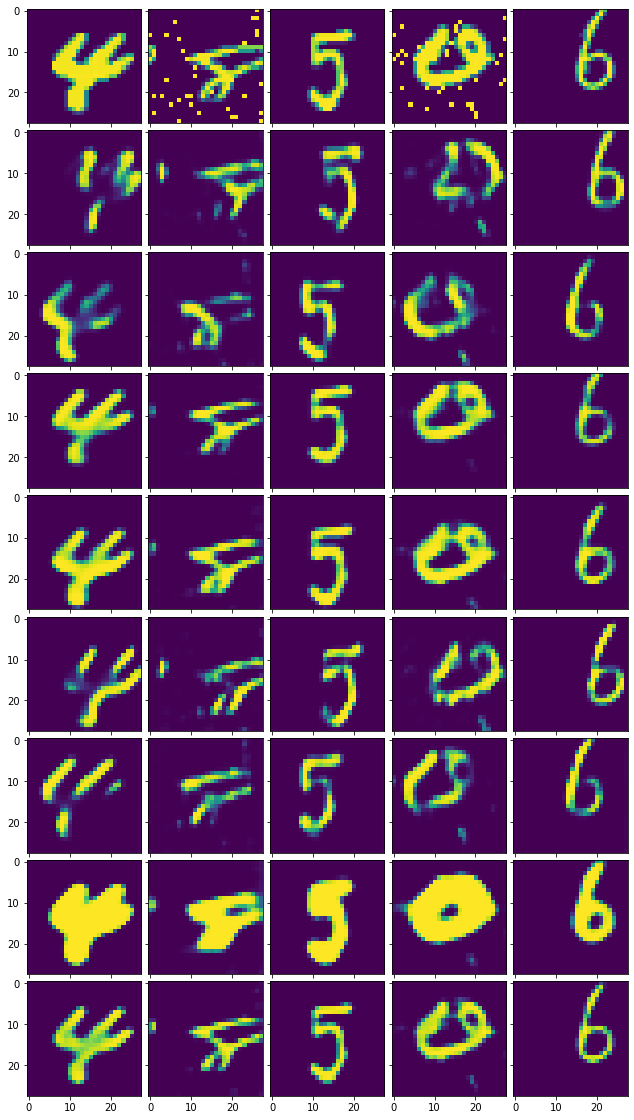

In [89]:
plot_output_grid(output)